In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import seaborn as sns
import math
import random
import joblib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
with open('../datasets/washing_machine_labels.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    print(line)

Energy Rating Data Dictionary for Clothes Washers (labelled) as at May 2015



Column - Column Identifier - Description

ApplStandard - Registration.regulatory_standard - This is the legal standard to which the appliance must comply

Brand - Model.brand_name - This is the manufacturers brand

Cap - rated_load_capacity - This is the rated capacity of the appliance in half kilogram increments only.

CEC Cold - cec_cold - This is the current Comparative Energy Consumption for the product on cold wash expressed as kilowatt hours per years.

CEC_ - cec_warm_wash - This is the current Comparative Energy Consumption for the product on warm wash expressed as kilowatt hours per years.

Cold Prog - cold_prog - Name of program used in cold wash tests

Cold Wat Cons - c_wtrcnsmp - Average cold water consumption in whole litres

Combination - is_combination_washer_dryer - The appliance may be a combination washer/dryer

Control - control - The appliance may have a control a timer or is autosensing


In [3]:
data = pd.read_csv('../datasets/washing_machine.csv')
ranges = {}
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ApplStandard              790 non-null    object 
 1   Brand                     790 non-null    object 
 2   Cap                       790 non-null    float64
 3   CEC Cold                  273 non-null    float64
 4   CEC_                      790 non-null    int64  
 5   Cold Prog                 253 non-null    object 
 6   Cold Wat Cons             210 non-null    float64
 7   Combination               783 non-null    object 
 8   Conn_Mode                 790 non-null    object 
 9   Country                   790 non-null    object 
 10  delayStartMode            782 non-null    object 
 11  Depth                     415 non-null    float64
 12  DetergentType             783 non-null    object 
 13  Height                    415 non-null    float64
 14  Hot Wat Co

In [4]:
# Let us first find see the features which we might have to drop
print(data.columns.values, '\n')

# As we can see here, Grand Date and Old Star Rating are entirely empty so we can drop them
print(data.isnull().sum(), '\n')

# For each of these features, more than 97% of the values are the same, we can drop these as well
print(pd.value_counts(data['N-Standard']), '\n')
print(pd.value_counts(data['Product Class']), '\n')
print(pd.value_counts(data['SubmitStatus']), '\n')
print(pd.value_counts(data['Availability Status']), '\n')
print(data['Tot Wat Cons'].value_counts(),'\n')

# Since Cold Prog is barely informative without a proper convention, we can drop it,
# Since Hot Wat Cons and Cold Water (L) has more than 70% values missing, we drop that as well
columns = ['Cold Prog', 'Family Name', 'Tot Wat Cons', 'Model No', 'WEI', 'Hot Water (L)', 'postProgenergy', 'New SRI', 'Registration Number', 'MachineAction', 'Hot Wat Cons', 'Test Prog Time', 'Cold Water (L)', 'N-Standard', 'Sold_in', 'Submit_ID', 'GrandDate', 'SubmitStatus', 'Product Class', 'Product Website', 'Star Rating (old)', 'Star Image Large', 'ExpDate', 'Star Image Small', 'Availability Status', 'Representative Brand URL']
data.drop(columns, axis=1, inplace=True)

['ApplStandard' 'Brand' 'Cap' 'CEC Cold' 'CEC_' 'Cold Prog'
 'Cold Wat Cons' 'Combination' 'Conn_Mode' 'Country' 'delayStartMode'
 'Depth' 'DetergentType' 'Height' 'Hot Wat Cons' 'internal_heater'
 'Loading' 'MachineAction' 'Model No' 'Family Name' 'N-Standard' 'New SRI'
 'New Star' 'postProgenergy' 'powerConsMode' 'Prog Name' 'Sold_in'
 'standbyPowerUsage' 'Submit_ID' 'SubmitStatus' 'Test Prog Time'
 'Tot Wat Cons' 'Type' 'WEI' 'Width' 'ExpDate' 'GrandDate' 'Product Class'
 'Availability Status' 'Product Website' 'Representative Brand URL'
 'Program Time' 'Hot Water (L)' 'Cold Water (L)' 'Star Rating (old)'
 'Star Image Large' 'Star Image Small' 'Registration Number'] 

ApplStandard                  0
Brand                         0
Cap                           0
CEC Cold                    517
CEC_                          0
Cold Prog                   537
Cold Wat Cons               580
Combination                   7
Conn_Mode                     0
Country                       0


In [5]:
print(data.info())
data.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplStandard       790 non-null    object 
 1   Brand              790 non-null    object 
 2   Cap                790 non-null    float64
 3   CEC Cold           273 non-null    float64
 4   CEC_               790 non-null    int64  
 5   Cold Wat Cons      210 non-null    float64
 6   Combination        783 non-null    object 
 7   Conn_Mode          790 non-null    object 
 8   Country            790 non-null    object 
 9   delayStartMode     782 non-null    object 
 10  Depth              415 non-null    float64
 11  DetergentType      783 non-null    object 
 12  Height             415 non-null    float64
 13  internal_heater    782 non-null    object 
 14  Loading            783 non-null    object 
 15  New Star           790 non-null    float64
 16  powerConsMode      782 non

,ApplStandard,Brand,Cap,CEC Cold,CEC_,Cold Wat Cons,Combination,Conn_Mode,Country,delayStartMode,...,Height,internal_heater,Loading,New Star,powerConsMode,Prog Name,standbyPowerUsage,Type,Width,Program Time
0,AS/NZS 2040.2:2000 (Legacy),Haier,5.0,90.0,480,107.47,NaN,Dual,China,NaN,...,NaN,NaN,Top,1.5,NaN,"Warm/cold, Large, Normal wash",NaN,Non-Drum,NaN,60.0
1,AS/NZS 2040.2:2000 (Legacy),INDESIT,5.5,230.0,240,75.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.5,NaN,"Cotton No 4, 40C",NaN,Drum,NaN,90.0
2,AS/NZS 2040.2:2000 (Legacy),INDESIT,6.0,266.0,277,54.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.5,NaN,"Cotton No3, 40 C",NaN,Drum,NaN,145.0
3,AS/NZS 2040.2:2000 (Legacy),INDESIT,6.0,133.0,327,57.00,NaN,Dual,Italy,NaN,...,NaN,NaN,Front,3.0,NaN,"No 2, 40 C",NaN,Drum,NaN,120.0


In [6]:
# Fill up missing value columns
missing_values_columns = [column for column in data.columns.values if data[column].isnull().sum()>0]
print(missing_values_columns)

['CEC Cold', 'Cold Wat Cons', 'Combination', 'delayStartMode', 'Depth', 'DetergentType', 'Height', 'internal_heater', 'Loading', 'powerConsMode', 'Prog Name', 'standbyPowerUsage', 'Width']


In [7]:
# Firstly we shall combine Brand and Country into a single column
Brand_Country = []
for index, row in data.iterrows():
    if len(row['Country'])>1: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1] + row['Country'][1][:1]).upper())
    else: 
        Brand_Country.append((row['Brand'][:2] + row['Country'][0][:1]).upper())
data['Brand_Country'] = Brand_Country
data['Brand_Country']

0      HACH
1      INIT
2      INIT
3      INIT
4      SMCH
       ... 
785    LGVI
786    LGVI
787    LGVI
788    LGVI
789    LECH
Name: Brand_Country, Length: 790, dtype: object

mode of cec_cold -  150.0
0      47
166    11
102    10
150    10
201    10
       ..
119     1
117     1
96      1
82      1
126     1
Name: CEC Cold, Length: 201, dtype: int64
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


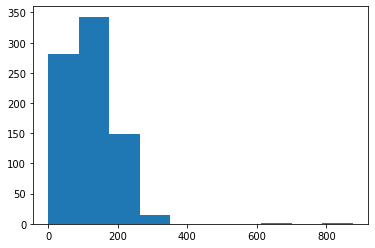

0    226
1    202
2    192
3    170
Name: CEC Cold, dtype: int64


In [8]:
mode_cec_cold_overall = data['CEC Cold'].value_counts().index[1]
print('mode of cec_cold - ', mode_cec_cold_overall)
mean = data['CEC Cold'].mean()
std = data['CEC Cold'].std()
null_count = data["CEC Cold"].isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data['CEC Cold'][np.isnan(data['CEC Cold'])] = null_random
data['CEC Cold'] = data['CEC Cold'].astype(int)
print(data['CEC Cold'].value_counts())

plt.hist(data['CEC Cold'])
plt.show()

for index, row in data.iterrows():
    cec_cold = data.at[index, 'CEC Cold']
    if cec_cold>=0 and cec_cold<75: value = 0
    elif cec_cold>=75 and cec_cold<125: value = 1
    elif cec_cold>=125 and cec_cold<175: value = 2
    elif cec_cold>=175: value = 3
    data.at[index, 'CEC Cold'] = value

data['CEC Cold'] = data['CEC Cold'].astype(int)

ranges['CEC Cold'] = {0:(0,75),1:(75,125),2:(125,175),3:(175,800)}

print(data['CEC Cold'].value_counts())

544    22
320    15
762    14
306    13
250    13
       ..
551     1
359     1
536     1
365     1
984     1
Name: CEC_, Length: 251, dtype: int64


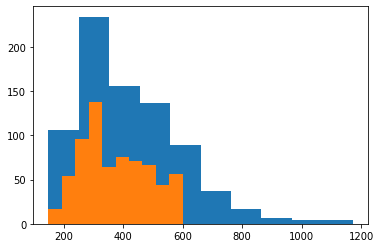

1    248
2    213
0    165
3    164
Name: CEC_, dtype: int64

In [9]:
print(data.CEC_.value_counts())

plt.hist(data.CEC_)
plt.hist(data.loc[data.CEC_<=600, 'CEC_'])
plt.show()

for index, rows in data.iterrows():
    cec = data.at[index, 'CEC_']
    if cec<=280: value = 0
    elif cec>280 and cec<=400: value = 1
    elif cec>400 and cec<=550: value = 2
    elif cec>550: value = 3
    
    data.at[index, 'CEC_'] = value

data.CEC_ = data.CEC_.astype(int)

ranges['CEC_'] = {0:(149,280),1:(280,400),2:(400,550),3:(550,1200)}
data.CEC_.value_counts()

In [10]:
cold_water_cons_mode = data['Cold Wat Cons'].value_counts().index[1]
print('mode of cold_wat_cons - ', cold_water_cons_mode)
mean = data['Cold Wat Cons'].mean()
std = data['Cold Wat Cons'].std()
null_count = data['Cold Wat Cons'].isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data['Cold Wat Cons'][np.isnan(data['Cold Wat Cons'])] = null_random
data['Cold Wat Cons'] = data['Cold Wat Cons'].astype(int)

for index, row in data.iterrows():
    cold_wat_cons = data.at[index, 'Cold Wat Cons']
    if cold_wat_cons>=0 and cold_wat_cons<50: value = 0
    elif cold_wat_cons>=50 and cold_wat_cons<80: value = 1
    elif cold_wat_cons>=80: value = 2
    data.at[index, 'Cold Wat Cons'] = value

ranges['Cold Wat Cons'] = {0:(0,50),1:(50,80),2:(80,265)}
    
print(data['Cold Wat Cons'].value_counts())

mode of cold_wat_cons -  60.0
1    291
2    274
0    225
Name: Cold Wat Cons, dtype: int64
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


mode of combination -  False


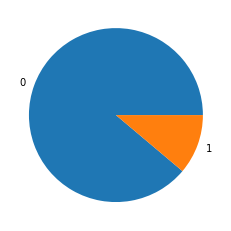

In [11]:
combination_mode = data.Combination.value_counts().index[0]
print('mode of combination - ', combination_mode)
data.Combination = data.Combination.fillna(0)
for index, row in data.iterrows():
    if not data.at[index, 'Combination']:
        data.at[index, 'Combination'] = 0
    else: 
        data.at[index, 'Combination'] = 1

data['Combination'] = data['Combination'].astype(int)
data['Combination'].value_counts()
plt.pie(data.Combination.value_counts(), labels=data.Combination.value_counts().index)
plt.show()

mode of delayStartMode -  True


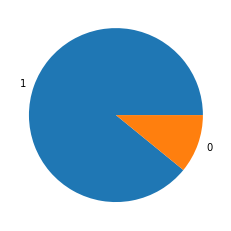

In [12]:
delayStart_mode = data.delayStartMode.value_counts().index[0]
print('mode of delayStartMode - ', delayStart_mode)
data.delayStartMode = data.delayStartMode.fillna(0)
for index, row in data.iterrows():
    if not data.at[index, 'delayStartMode']:
        data.at[index, 'delayStartMode'] = 0
    else: 
        data.at[index, 'delayStartMode'] = 1

data['delayStartMode'] = data['delayStartMode'].astype(int)
data['delayStartMode'].value_counts()

ranges['delayStartMode'] = {0: ['False'], 1:['True']}

plt.pie(data.delayStartMode.value_counts(), labels=data.delayStartMode.value_counts().index)
plt.show()

565.0    48
595.0    24
560.0    19
625.0    18
600.0    16
         ..
517.0     1
950.0     1
555.0     1
835.0     1
637.0     1
Name: Depth, Length: 72, dtype: int64


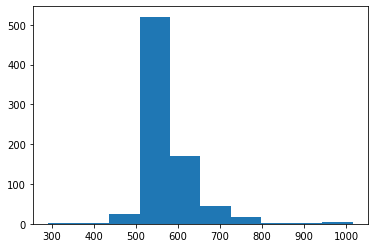

1    397
2    204
0    138
3     51
Name: Depth, dtype: int64

In [13]:
depth_mode = data['Depth'].value_counts().index[0]
print(data.Depth.value_counts())
data.Depth = data.Depth.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Depth']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Depth'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Depth'].mode().values[0])
        if brand_country_mode!=0:
            depth = brand_country_mode
        elif country_mode!=0:
            depth = country_mode
        else: 
            depth = depth_mode
    else: 
        depth = int(data.at[index, 'Depth'])
    
    data.at[index, 'Depth'] = depth
    
plt.hist(data.Depth)
plt.show()

data.Depth = data.Depth.astype(int)
for index, rows in data.iterrows():
    depth = data.at[index, 'Depth']
    if depth>=292 and depth<565: value = 0
    elif depth==565: value = 1
    elif depth>=570 and depth<700: value = 2
    elif depth>=700: value = 3
        
    data.at[index, 'Depth'] = value
    
data.Depth = data.Depth.astype(int)
data.Depth.value_counts()

mode is - Drum


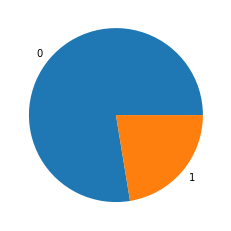

In [14]:
mode_detergentType = data.DetergentType.value_counts().index[0]
print('mode is -', mode_detergentType)
data.DetergentType = data.DetergentType.fillna(mode_detergentType)
for index, row in data.iterrows():
    if data.at[index, 'DetergentType'] == 'Drum':
        value = 0
    else: value = 1
    data.at[index, 'DetergentType'] = value

data.DetergentType = data.DetergentType.astype(int)
data.DetergentType.value_counts()
plt.pie(data.DetergentType.value_counts(), labels=data.DetergentType.value_counts().index)
plt.show()

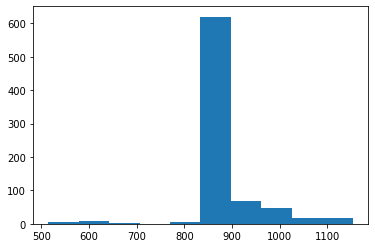

1    551
2    154
0     85
Name: Height, dtype: int64

In [15]:
height_mode = data['Height'].value_counts().index[0]
# print(data.Height.value_counts())
data.Height = data.Height.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Height']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Height'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Height'].mode().values[0])
        if brand_country_mode!=0:
            height = brand_country_mode
        elif country_mode!=0:
            height = country_mode
        else: 
            height = height_mode
    else: 
        height = int(data.at[index, 'Height'])
    
    data.at[index, 'Height'] = height

plt.hist(data.Height)
plt.show()

for index, row in data.iterrows():
    height = data.at[index, 'Height']
    if height>=515 and height<850: value = 0
    elif height==850: value = 1
    else: value = 2
    data.at[index, 'Height'] = value
    
data.Height = data.Height.astype(int)
data.Height.value_counts()

Yes on the warm wash program only              456
No                                             278
Yes on both the warm and cold wash programs     48
Name: internal_heater, dtype: int64


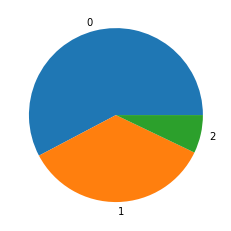

In [16]:
mode_internal_heater = data.internal_heater.value_counts().index[0]
print(data.internal_heater.value_counts())
data.internal_heater.fillna(mode_internal_heater)
for index, rows in data.iterrows():
    if data.at[index, 'internal_heater']=='Yes on the warm wash program only':
        value = 0
    elif data.at[index, 'internal_heater']=='No':
        value = 1
    else: value = 2
    data.at[index, 'internal_heater'] = value

data.internal_heater = data.internal_heater.astype(int)
data.internal_heater.value_counts()
plt.pie(data.internal_heater.value_counts(), labels=data.internal_heater.value_counts().index)
plt.show()

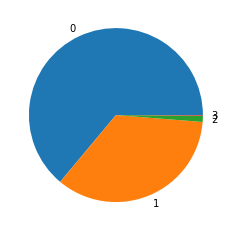

In [17]:
mode_loading = data.Loading.value_counts().index[0]
data.Loading = data.Loading.fillna(mode_loading)

data.Loading = data.Loading.map({'Front':0, 'Top':1, 'Twin Tub':2, 'dual drum, front load':3}).astype(int)
data.Loading.value_counts()

plt.pie(data.Loading.value_counts(), labels=data.Loading.value_counts().index)
plt.show()

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


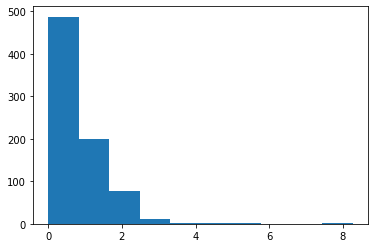

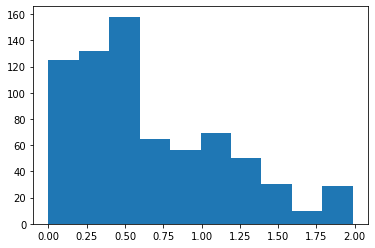

0    272
1    202
2    191
3    125
Name: powerConsMode, dtype: int64

In [18]:
# As we can see the data is mostly between 0 and 2 hence we shall find the count 
# between the range to get a better idea
plt.hist(data.powerConsMode)
plt.show()

plt.hist(data.loc[data['powerConsMode']<2, 'powerConsMode'])
plt.show()

data.powerConsMode = data.powerConsMode.fillna(0.0)
for index, rows in data.iterrows():
    powerConsMode = data.at[index, 'powerConsMode']   
    if powerConsMode<=0.4: value = 0
    elif powerConsMode>0.4 and powerConsMode<=0.75: value = 1
    elif powerConsMode>0.75 and powerConsMode<=1.4: value = 2
    elif powerConsMode>1.4: value = 3
    
    data.at[index, 'powerConsMode'] = value
    
data.powerConsMode = data.powerConsMode.astype(int)

ranges['powerConsMode'] = {0:(0,0.4),1:(0.4,0.75),2:(0.75,1.4),3:(1.4,8)}

data.powerConsMode.value_counts()

', 'ultra', 'cold', '&', 'hot', 'wash', 'soak', '2hrs']
438 ['cotton', 'with', 'selection', 'temp.', '60', 'ºc’', 'and', 'spin', 'speed', '1200']
439 ['water', 'saving', 'water', 'level', '7', 'wash', 'time', '24', 'min', 'rinse', '3', 'spin', 'extra', 'high', 'temp.', 'cold', 'and', 'hot']
440 ['water', 'saving', 'water', 'level', '7', 'wash', 'time', '24', 'min', 'rinse', '3', 'spin', 'extra', 'high', 'temp.', 'cold', 'and', 'hot']
441 ['water', 'saving', 'water', 'level', '8', 'wash', 'time', '50min', 'rinse', '3', 'spin', 'medium', 'temp.', 'cold', 'and', 'hot']
442 ['water', 'saving', 'water', 'level', '8', 'wash', 'time', '50min', 'rinse', '3', 'spin', 'medium', 'temp.', 'cold', 'and', 'hot']
443 ['cotton', '60', 'degrees', '1200rpm', 'program']
444 ['cottons', 'wash', '40°c', '1400', 'eco']
446 ['cottons', '40c']
447 ['cottons', 'wash', '40°c', '1400', 'eco']
448 ['cotton', '40(degrees)c', 'intensive', '1400', 'rpm', 'seven', 'times', 'per', 'week']
449 ['cotton', 'with', 'selec

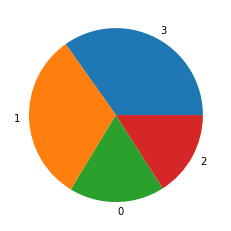

In [19]:
# data['Prog Name'].value_counts()
def return_features(data, index):
    program = data.at[index, 'Prog Name']
    if isinstance(program, float): return []
    if '/' in program:
        types = program.split('/')
        program = ''
        for t in types:
            program+=t+' '
    if ',' in program:
        types = program.split(',')
        program = ''
        for t in types:
            program+=t+' '
    keywords = program.split(' ')
    features = []
    for i in keywords: 
        i = i.strip()
        if i not in ['', '-']: features.append(i.lower())
    print(index, features)
    return features

# General categories - Normal, Heavy, Eco
for index, row in data.iterrows():
    names = return_features(data, index)
    if 'normal' in names: value = 0
    elif 'eco' in names: value = 1
    elif 'cotton' in names: value = 2
    else: value = 3
    
    data.at[index, 'Prog Name'] = value

data['Prog Name'] = data['Prog Name'].astype(int)
data['Prog Name'].value_counts()
plt.pie(data['Prog Name'].value_counts(), labels=data['Prog Name'].value_counts().index)
plt.show()

mode of standby power -  0.5
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


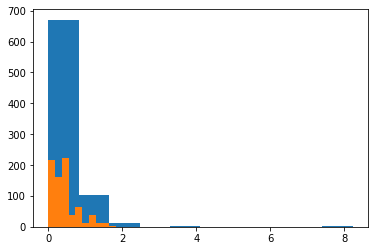

0.00000    80
0.50000    40
0.10000    27
0.20000    24
1.10000    21
           ..
0.49100     1
0.12400     1
0.13538     1
0.18020     1
0.45800     1
Name: standbyPowerUsage, Length: 169, dtype: int64
1    308
0    271
2    211
Name: standbyPowerUsage, dtype: int64


In [20]:
mode_standby_power = data.standbyPowerUsage.value_counts().index[1]
print('mode of standby power - ', mode_standby_power)
mean = data.standbyPowerUsage.mean()
std = data.standbyPowerUsage.std()
null_count = data.standbyPowerUsage.isnull().sum()
null_random = np.random.randint(mean - std, mean + std, size=null_count)
data.standbyPowerUsage[np.isnan(data.standbyPowerUsage)] = null_random

plt.hist(data.standbyPowerUsage)
plt.hist(data.loc[data.standbyPowerUsage<2, 'standbyPowerUsage'])
plt.show()

print(data.standbyPowerUsage.value_counts())
# print(data['Active Standby Power'].min(), data['Active Standby Power'].max())
for index, rows in data.iterrows():
    standby_power = data.at[index, 'standbyPowerUsage']
    
    if standby_power<=0.25: value = 0
    elif standby_power>0.25 and standby_power<=0.5: value = 1
    elif standby_power>0.5 : value = 2

    data.at[index, 'standbyPowerUsage'] = value

data.standbyPowerUsage = data.standbyPowerUsage.astype(int)

ranges['standbyPowerUsage'] = {0:(0,0.25),1:(0.25,0.5),2:(0.5,8)}
print(data.standbyPowerUsage.value_counts())

595.0    131
600.0     91
601.0     25
550.0     23
597.0     14
596.0     14
690.0     11
686.0     11
540.0     11
545.0      8
605.0      7
580.0      6
870.0      6
520.0      6
530.0      5
632.0      5
525.0      5
620.0      4
640.0      3
590.0      3
902.0      2
761.0      2
560.0      2
718.0      2
645.0      2
570.0      2
526.0      2
685.0      2
700.0      2
593.0      1
840.0      1
660.0      1
585.0      1
510.0      1
581.0      1
665.0      1
515.0      1
Name: Width, dtype: int64


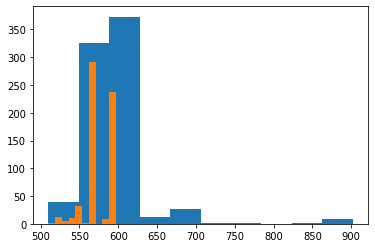

0    355
1    247
2    188
Name: Width, dtype: int64

In [21]:
width_mode = data['Width'].value_counts().index[0]
print(data.Width.value_counts())
data.Width = data.Width.fillna(0)
for index, row in data.iterrows():
    if int(data.at[index, 'Width']) == 0:
        brand_country_mode = int(data.loc[data['Brand_Country']==row['Brand_Country']]['Width'].mode().values[0])
        country_mode = int(data.loc[data['Country']==row['Country']]['Width'].mode().values[0])
        if brand_country_mode!=0:
            width = brand_country_mode
        elif country_mode!=0:
            width = country_mode
        else: 
            width = depth_mode
    else: 
        width = int(data.at[index, 'Width'])
    
    data.at[index, 'Width'] = width
    
plt.hist(data.Width)
plt.hist(data.loc[data.Width<600, 'Width'])
plt.show()

data.Depth = data.Depth.astype(int)
for index, rows in data.iterrows():
    width = data.at[index, 'Width']
    if width<=565: value = 0
    elif width>=570 and width<600: value = 1
    elif width>=600: value = 2

    data.at[index, 'Width'] = value

data.Width = data.Width.astype(int)
data.Width.value_counts()

In [22]:
# As we can see we have successfully removed all the missing values
# we still have to convert several columns into integer classes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplStandard       790 non-null    object 
 1   Brand              790 non-null    object 
 2   Cap                790 non-null    float64
 3   CEC Cold           790 non-null    int64  
 4   CEC_               790 non-null    int64  
 5   Cold Wat Cons      790 non-null    int64  
 6   Combination        790 non-null    int64  
 7   Conn_Mode          790 non-null    object 
 8   Country            790 non-null    object 
 9   delayStartMode     790 non-null    int64  
 10  Depth              790 non-null    int64  
 11  DetergentType      790 non-null    int64  
 12  Height             790 non-null    int64  
 13  internal_heater    790 non-null    int64  
 14  Loading            790 non-null    int64  
 15  New Star           790 non-null    float64
 16  powerConsMode      790 non

In [23]:
# As we can see we have removed all the null values are removed, now we must convert all the other data type
# to int type, by mapping boolean and objects to int
ApplStandard_types = {'AS/NZS 2040.2:2005': 0, 'AS/NZS 2040.2:2005 (Legacy)': 1, 'AS/NZS 2040.2:2000 (Legacy)': 2, 'Greenhouse and Energy Minimum Standards (Clothes Washing Machines) Determination 2015': 3, 'Greenhouse and Energy Minimum Standards (Clothes Washing Machines) Determination 2012': 4}
data['ApplStandard'] = data['ApplStandard'].map(ApplStandard_types).astype(int)
data['Conn_Mode'] = data['Conn_Mode'].map({'Dual':0, 'Cold': 1}).astype(int)
data['Type'] = data['Type'].map({'Drum':0, 'Non-Drum': 1}).astype(int)

ranges['Conn_Mode'] = {0:['Dual'],1:['Cold']}
ranges['Type'] = {0:['Drum'],1:['Non-Drum']}

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ApplStandard       790 non-null    int64  
 1   Brand              790 non-null    object 
 2   Cap                790 non-null    float64
 3   CEC Cold           790 non-null    int64  
 4   CEC_               790 non-null    int64  
 5   Cold Wat Cons      790 non-null    int64  
 6   Combination        790 non-null    int64  
 7   Conn_Mode          790 non-null    int64  
 8   Country            790 non-null    object 
 9   delayStartMode     790 non-null    int64  
 10  Depth              790 non-null    int64  
 11  DetergentType      790 non-null    int64  
 12  Height             790 non-null    int64  
 13  internal_heater    790 non-null    int64  
 14  Loading            790 non-null    int64  
 15  New Star           790 non-null    float64
 16  powerConsMode      790 non

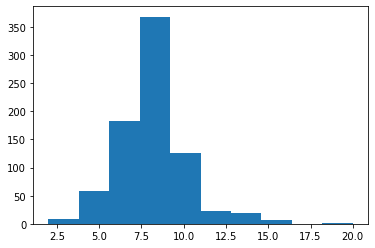

8.0     146
7.0     111
10.0    101
9.0      79
7.5      73
8.5      70
6.0      51
5.5      35
9.5      24
6.5      21
5.0      20
11.0     11
12.0     11
13.0     10
14.0      9
16.0      5
2.0       4
2.5       3
4.5       2
3.0       1
15.0      1
4.0       1
20.0      1
Name: Cap, dtype: int64


3    252
2    216
1    184
0    138
Name: Cap, dtype: int64

In [24]:
plt.hist(data.Cap)
plt.show()
print(data.Cap.value_counts())

for index, row in data.iterrows():
    cap = data.at[index, 'Cap']
    if cap<7: value = 0
    elif cap>=7 and cap<8: value = 1
    elif cap>=8 and cap<9: value = 2
    else: value = 3
    
    data.at[index, 'Cap'] = value

data.Cap = data.Cap.astype(int)

ranges['Cap'] = {0:(2,7),1:(7,8),2:(8,9),3:(9,20)}

data.Cap.value_counts()

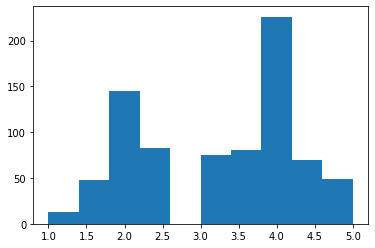

4.0    226
2.0    145
2.5     83
3.5     81
3.0     75
4.5     70
5.0     49
1.5     48
1.0     13
Name: New Star, dtype: int64


2    345
1    239
0    206
Name: New Star, dtype: int64

In [25]:
plt.hist(data['New Star'])
plt.show()

print(data['New Star'].value_counts())
for index, rows in data.iterrows():
    star = data.at[index, 'New Star']
    if star<=2: value = 0
    elif star>2 and star<4: value = 1
    else: value = 2

    data.at[index, 'New Star'] = value

data['New Star'] = data['New Star'].astype(int)
data['New Star'].value_counts()

186.00    15
192.00    14
232.00    13
300.00    13
240.00    12
          ..
306.76     1
265.39     1
216.58     1
148.77     1
351.00     1
Name: Program Time, Length: 285, dtype: int64


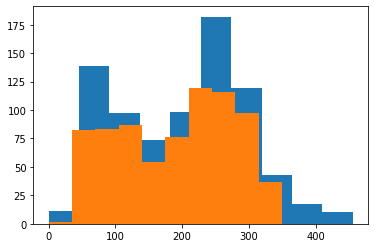

1    298
2    275
0    217
Name: Program Time, dtype: int64


In [26]:
print(data['Program Time'].value_counts())

plt.hist(data['Program Time'])
plt.hist(data.loc[data['Program Time']<350, 'Program Time'])
plt.show()

for index, rows in data.iterrows():
    time = data.at[index, 'Program Time']
    
    if time<=125: value = 0
    elif time>125 and time<250: value = 1
    else: value = 2
    
    data.at[index, 'Program Time'] = value

data['Program Time'] = data['Program Time'].astype(int)

ranges['Program Time'] = {0:(20,125),1:(125,250),2:(250,500)}

print(data['Program Time'].value_counts())

In [27]:
# We have converted all the initial types into integer type
# For now we shall not consider the effects of Brand_country, Brand and Country
data.drop(['Brand_Country', 'Brand', 'Country'], axis=1, inplace=True)
data.head(3)

,ApplStandard,Cap,CEC Cold,CEC_,Cold Wat Cons,Combination,Conn_Mode,delayStartMode,Depth,DetergentType,Height,internal_heater,Loading,New Star,powerConsMode,Prog Name,standbyPowerUsage,Type,Width,Program Time
0,2,0,1,2,2,0,0,0,1,0,1,2,1,0,0,0,0,1,0,0
1,2,0,3,0,1,0,0,0,1,0,1,2,0,1,0,2,0,0,0,0
2,2,0,3,0,1,0,0,0,1,0,1,2,0,1,0,2,0,0,0,1


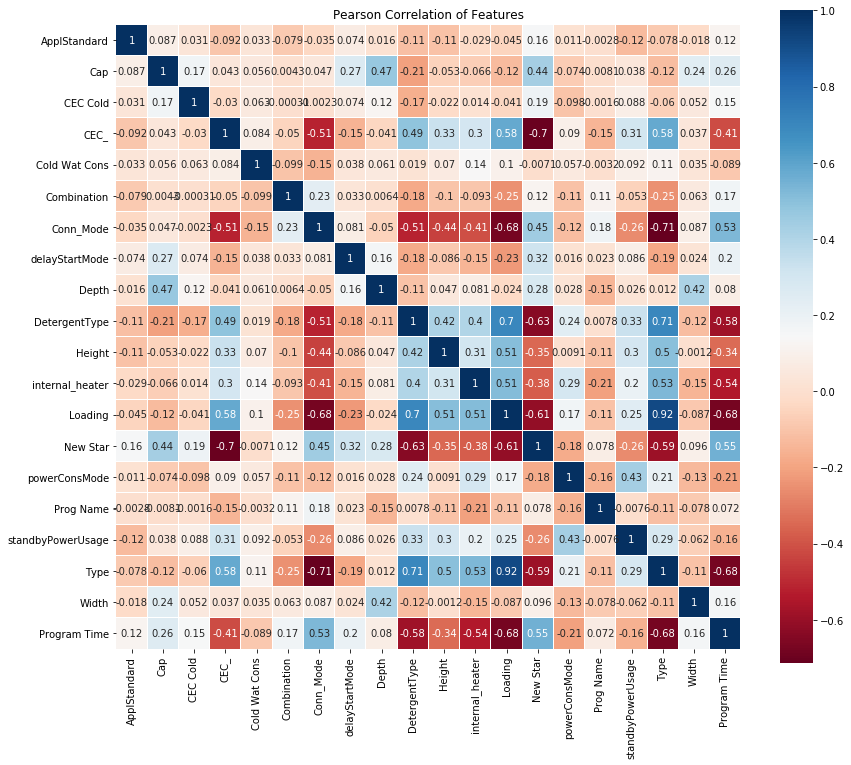

In [28]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, annot=True)

In [29]:
# As we can see, the features Loading, Type and DetergentType are highly correlated with each other, so we can drop one of them 
# to reduce redundancy. 
columns = ['Loading', 'DetergentType']

# We can also remove the features which are really poorly correlated with New Star
columns+=['ApplStandard','CEC Cold','Cold Wat Cons','Combination','Prog Name','Width', 'Depth', 'Height', 'powerConsMode']

data.drop(columns, axis=1, inplace=True)
data.head(3)

,Cap,CEC_,Conn_Mode,delayStartMode,internal_heater,New Star,standbyPowerUsage,Type,Program Time
0,0,2,0,0,2,0,0,1,0
1,0,0,0,0,2,1,0,0,0
2,0,0,0,0,2,1,0,0,1


In [30]:
problemFeatures = []
allFeatures = list(data.columns)
allFeatures.remove('New Star')
for feature in allFeatures:
    if abs(data[feature].corr(data['New Star']))>0.3:
        print(feature)
        problemFeatures.append(feature)

Cap
CEC_
Conn_Mode
delayStartMode
internal_heater
Type
Program Time


In [31]:
train_x = data.drop('New Star', axis=1)
train_y = data['New Star']
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)

train_y

636    1
279    1
270    0
402    0
488    2
      ..
461    1
425    2
522    1
286    2
614    1
Name: New Star, Length: 632, dtype: int64

In [32]:
# KNN Neighbours Classification
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='auto')
knn.fit(train_x, train_y)  
knn_predictions = knn.predict(train_x)  
knn_accuracy = round(knn.score(train_x, train_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(train_y, knn_predictions, average=None))
print("Recall score: ", recall_score(train_y, knn_predictions, average=None))
print("F Score: ", f1_score(train_y, knn_predictions, average=None))

# Since we are getting a reasonably good score, we can tune this classifier

Accuracy:  91.77
Precision score:  [0.92993631 0.86764706 0.94833948]
Recall score:  [0.91823899 0.87623762 0.94833948]
F Score:  [0.92405063 0.87192118 0.94833948]


In [33]:
knn = KNeighborsClassifier(n_neighbors = 3, leaf_size=5, algorithm='ball_tree')
knn.fit(test_x, test_y)  
knn_predictions = knn.predict(test_x)  
knn_accuracy = round(knn.score(test_x, test_y) * 100, 2)
print("Accuracy: " ,knn_accuracy)

print("Precision score: ", precision_score(test_y, knn_predictions, average=None))
print("Recall score: ", recall_score(test_y, knn_predictions, average=None))
print("F Score: ", f1_score(test_y, knn_predictions, average=None))

Accuracy:  91.77
Precision score:  [0.91666667 0.85294118 0.94736842]
Recall score:  [0.93617021 0.78378378 0.97297297]
F Score:  [0.92631579 0.81690141 0.96      ]


In [34]:
joblib.dump(knn, '../server/weights/washing_machine_weight.sav')

['../server/weights/washing_machine_weight.sav']

In [35]:
specifications_for_0 = {}
for feature in problemFeatures:
    specifications_for_0[feature] = list(data.loc[data['New Star']==0, feature].value_counts().index[:1])
print(specifications_for_0)

ranges['specifications_for_0'] = specifications_for_0

{'Cap': [0], 'CEC_': [3], 'Conn_Mode': [0], 'delayStartMode': [1], 'internal_heater': [1], 'Type': [1], 'Program Time': [0]}


In [36]:
specifications_for_1 = {}
for feature in problemFeatures:
    specifications_for_1[feature] = list(data.loc[data['New Star']==1, feature].value_counts().index[:1])
print(specifications_for_1)

ranges['specifications_for_1'] = specifications_for_1

{'Cap': [3], 'CEC_': [2], 'Conn_Mode': [0], 'delayStartMode': [1], 'internal_heater': [0], 'Type': [0], 'Program Time': [1]}


In [37]:
specifications_for_2 = {}
for feature in problemFeatures:
    specifications_for_2[feature] = list(data.loc[data['New Star']==2, feature].value_counts().index[:1])
print(specifications_for_2)

ranges['specifications_for_2'] = specifications_for_2

{'Cap': [2], 'CEC_': [1], 'Conn_Mode': [1], 'delayStartMode': [1], 'internal_heater': [0], 'Type': [0], 'Program Time': [2]}


In [38]:
# file = open('../server/inferences/data_ranges/washing_machine.json','w')
# json.dump(ranges,file)